In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue May  1 15:06:25 2023

@author: maria popovic
"""

from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister, Aer, execute
from numpy import pi, matrix, arcsin, sqrt, arccos
import matplotlib.pyplot as plt
from numpy import array, exp, append
import random
import math
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT, PhaseEstimation, CPhaseGate, RYGate, Reset
from qiskit.circuit import Parameter
from qiskit.opflow import X,Y,Z,I
from qiskit.extensions import UnitaryGate
from qiskit.quantum_info import SparsePauliOp
from mpmath import csc
from cmath import log

/var/folders/p2/sk8mfrx95pl68sgzcmlvccnm0000gn/T/ipykernel_26245/1975165918.py:18: DeprecationWarning: The ``qiskit.opflow`` module is deprecated as of qiskit-terra 0.24.0. It will be removed no earlier than 3 months after the release date. For code migration guidelines, visit https://qisk.it/opflow_migration.
  from qiskit.opflow import X,Y,Z,I


# Calibration of Vasicek parameters

In [2]:
### Load data time series ###

import pandas as pd

file = pd.read_excel('Backtest_Validation_Hist.xlsx',sheet_name='Daily returns')

data_daily = file['YIELDCURVE.EUR-MSWAP.ZERO.EUR(T365)'].tolist()

file2 = pd.read_excel('Backtest_Validation_Hist.xlsx',sheet_name='TS')

data = file2['YIELDCURVE.EUR-MSWAP.ZERO.EUR(T365)'].tolist()

data_initial_rate = []
data_yearly = []
index = 0
while (index + 251) < len(data_daily):
    data_initial_rate.append(data[index])
    data_yearly.append(sum(data_daily[index:index + 251]))
    index = index + 5
    

In [3]:
from numpy import random
from sklearn.metrics import mean_absolute_error
from numpy.linalg import eig


def Hamiltonian(vect):
    Ham = (1/4)*(vect[0] - vect[1] - vect[2] + vect[3])*(Z^Z) + \
          (1/4)*(vect[0] + vect[1] + vect[2] + vect[3])*(I^I) + \
          (1/4)*(vect[0] - vect[1] + vect[2] - vect[3])*(I^Z) + \
          (1/4)*(vect[0] + vect[1] - vect[2] - vect[3])*(Z^I)
    
    
    #Ham = Ham.to_matrix()
    return Ham


def vasicek(a, b, sigma, r0, dt):
    
    wt = random.normal(0, dt)
    rt = (a*b*dt + sigma*wt)/(1 + a*dt)
    dr = rt - r0

    return dr



# Calibration of parameter: a
b = 0.5
sigma = 1
dt = 1 # One year
N = len(data_yearly)

a_list = [4.2, 10, -0.5, -10]
eigenvalues = []

for a in a_list:
    theoretical_value = []
    for index in range(0,N):
        theoretical_value.append(vasicek(a, b, sigma, data_initial_rate[index], dt))
    mae = mean_absolute_error(theoretical_value, data_yearly)
    
    eigenvalues.append(mae)
        
H = Hamiltonian(eigenvalues)

U = H.exp_i() # Evolution operator for H with t = 1
U = U.to_matrix()
U_Dagger = matrix(U).getH()

U_Gate = UnitaryGate(U, label = 'U').control(1)
U_Dagger_Gate = UnitaryGate(U_Dagger, label = r'$U^{\dag}$').control(1)

# Quantum phase estimation (QPE)

In [31]:
def energy_state(result, n):
    
    num_result = int(result,2)
    
    if num_result == 0:
        
        energy_positive = 0
    
    else: 
        energy_positive = 2*pi*(2**(n) - num_result)/(2**(n))
    
    energy_negative = (-2*pi*num_result)/(2**(n))

    
    return energy_positive, energy_negative


def read_output(count):
    
    en_current = []
    state = []
    
    for index in range(0, len(list(count0.keys()))):
        st = list(count0.keys())[index][0] + list(count0.keys())[index][1]
        state.append(st)
        
    for index in range(0, len(list(count0.keys()))):
        curr = list(count0.keys())[index][8] + list(count0.keys())[index][9] + list(count0.keys())[index][10] + list(count0.keys())[index][11]
        en_current.append(energy_state(curr, 4)[0])
        
      
    return state, en_current
    

def quantum_phase_estimation(energy_register, state_register, unitary):
    
    phase_circuit = QuantumCircuit(energy_register, state_register, name='QPE')
    
    iqft = QFT(num_qubits = len(energy_register), do_swaps = True, inverse = True) 
    
    iqft = iqft.to_gate()
    
    for qubit in energy_register:
        phase_circuit.h(qubit)
    
    for index in range(0, len(energy_register)):
    
        counts = 1
        while counts <= 2**(index):
            phase_circuit.append(unitary, [energy_register[index], *state_register])
            counts = counts + 1

    phase_circuit.append(iqft,energy_register)
    
    phase_circuit = phase_circuit.to_gate()
    
    return phase_circuit

def inverse_quantum_phase_estimation(energy_register, state_register, unitary):
    
    phase_circuit = QuantumCircuit(energy_register, state_register, name=r'$QPE^{\dagger}$')
    
    qft = QFT(num_qubits = len(energy_register), do_swaps = True, inverse = False) 
    
    qft = qft.to_gate()
    
    phase_circuit.append(qft, energy_register)

    for index in range(0, len(energy_register)):
    
        counts = 1
        while counts <= 2**(len(energy_register) - 1 - index):
            phase_circuit.append(unitary, [energy_register[len(energy_register) - 1 - index], *state_register])
            counts = counts + 1
        
    for qubit in energy_register:
        phase_circuit.h(qubit)
        
    phase_circuit = phase_circuit.to_gate()

    return phase_circuit

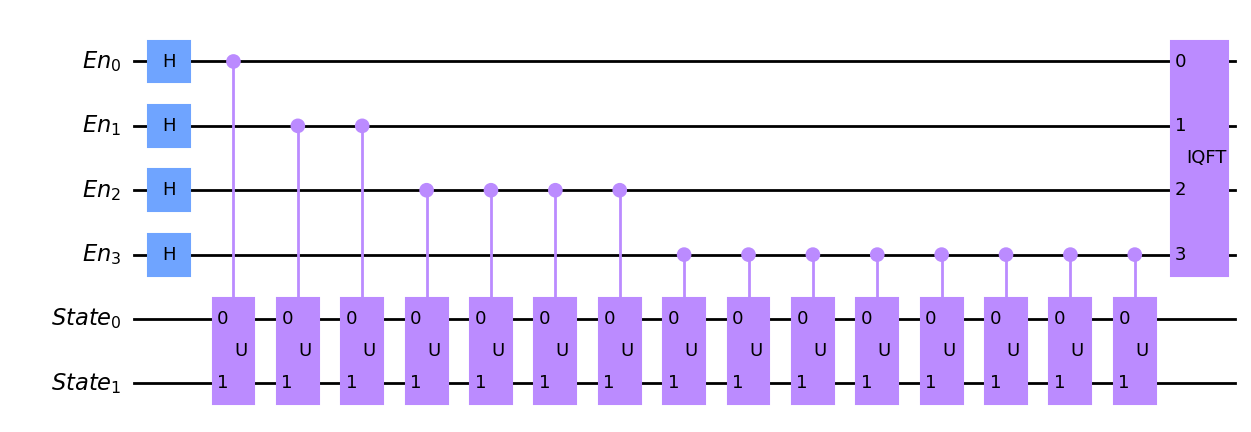

In [11]:
## TEST
en = QuantumRegister(4, name = 'En')
st = QuantumRegister(2, name = 'State')
test_qc = QuantumCircuit(en, st)

test_qc.append(quantum_phase_estimation(en, st, U_Gate), [*en, *st])

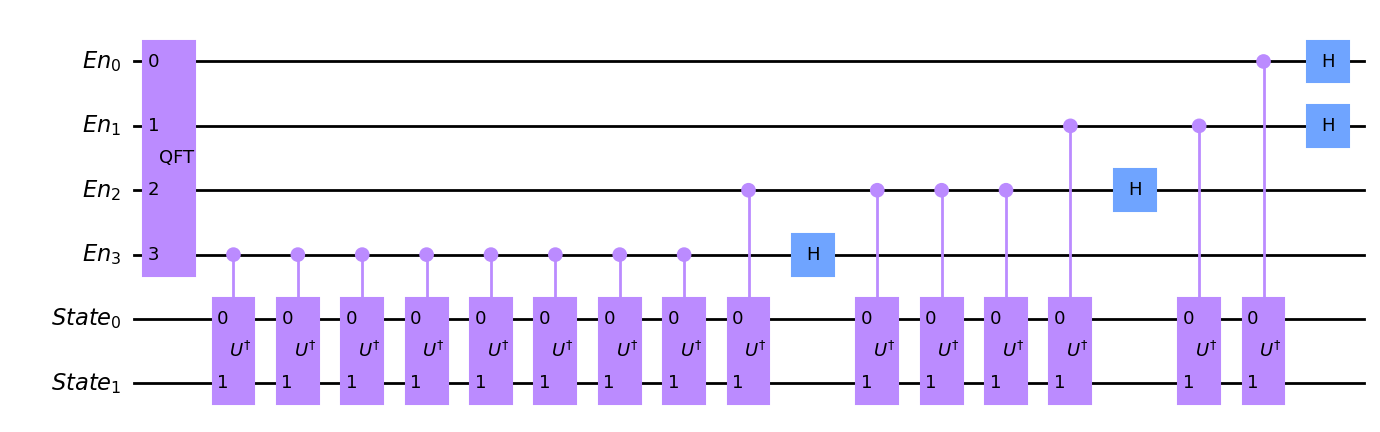

In [17]:
## TEST
en = QuantumRegister(4, name = 'En')
st = QuantumRegister(2, name = 'State')
test_qc = QuantumCircuit(en, st)

test_qc.append(inverse_quantum_phase_estimation(en, st, U_Dagger_Gate), [*en, *st])

# Iterative phase estimation (IPE)

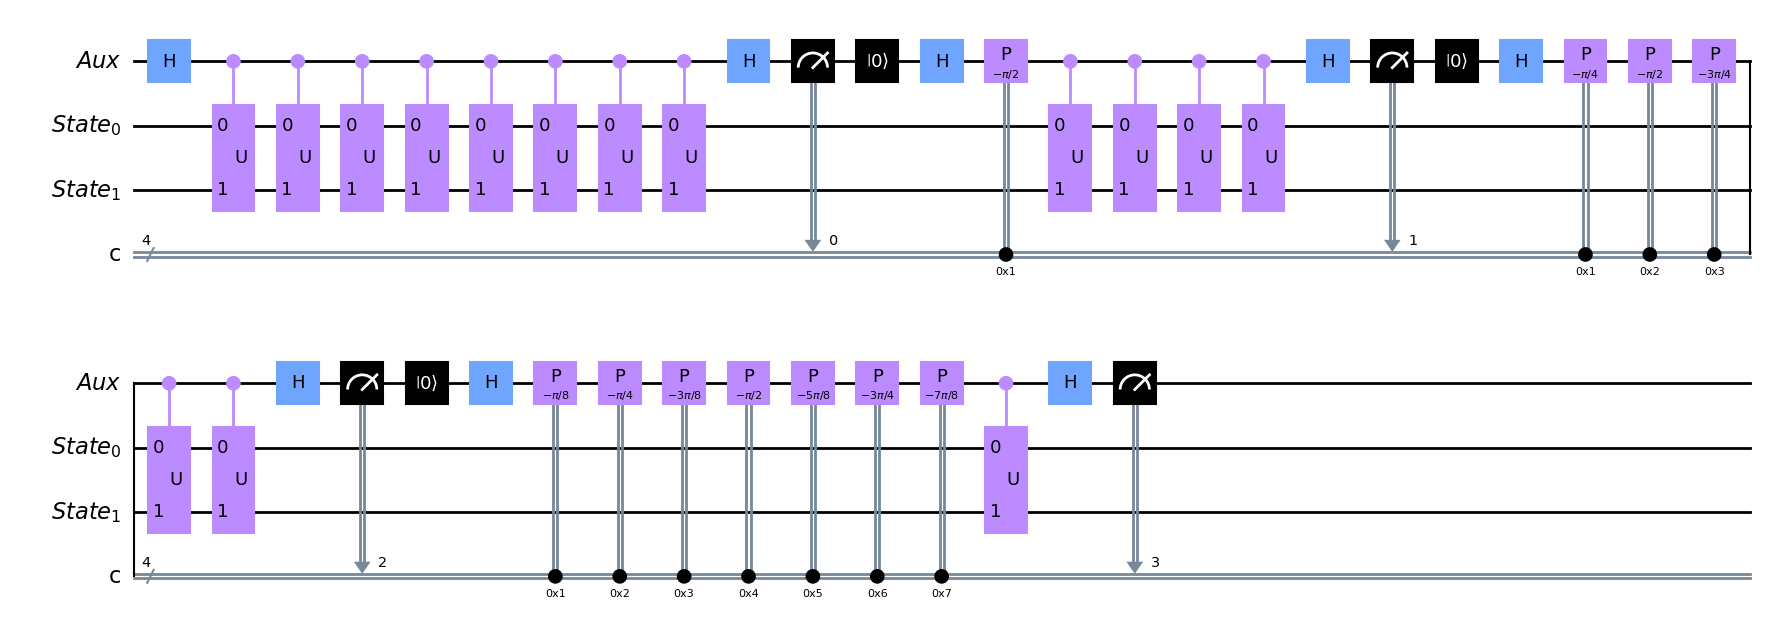

{'0.5': 2, '0.8125': 3, '0.9375': 1, '0.6875': 3, '0.5625': 2, '0.3125': 7, '0.875': 5, '0.625': 2, '0.1875': 495, '0.0625': 12, '0.25': 23, '0.375': 4, '0.125': 458, '0.0': 7}


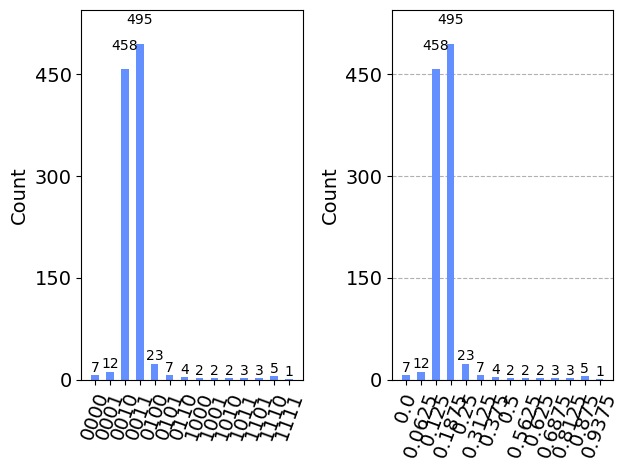

In [5]:
state_bits = 2
precision = 4
aux = QuantumRegister(1, name = 'Aux')
state_register = QuantumRegister(state_bits,name='State')
classical_register = ClassicalRegister(precision, name = 'c')
circuit2 = QuantumCircuit(aux, state_register, classical_register)
#circuit2.x(state_register[0])
#circuit2.x(state_register[1])

def iterative_phase_estimation(phase_circuit, m, state_register, aux, classical_register, unitary):
    
    def x_measurement(qc, qubit, cbit):
        """Measure 'qubit' in the X-basis, and store the result in 'cbit'"""
        qc.h(qubit)
        qc.measure(qubit, cbit)
    
    phase_circuit.h(aux)
    
    #
    for _ in range(2**(m - 1)):
        phase_circuit.append(unitary, [aux, *state_register])
    
    x_measurement(phase_circuit, aux, classical_register[0])
    
    phase_circuit.reset(aux)
    phase_circuit.h(aux)
    
    phase_circuit.p(-pi/2,aux).c_if(classical_register,1)
    #
    for _ in range(2**(m - 2)):
        phase_circuit.append(unitary, [aux, *state_register])
        
    x_measurement(phase_circuit, aux, classical_register[1])
    
    phase_circuit.reset(aux)
    phase_circuit.h(aux)
    
    phase_circuit.p(-pi/4,aux).c_if(classical_register,1)
    phase_circuit.p(-pi/2,aux).c_if(classical_register,2)
    phase_circuit.p(-3*pi/4,aux).c_if(classical_register,3)
    #
    for _ in range(2**(m - 3)):
        phase_circuit.append(unitary, [aux, *state_register])
    
    x_measurement(phase_circuit, aux, classical_register[2])
    
    phase_circuit.reset(aux)
    phase_circuit.h(aux)
        
    phase_circuit.p(-pi/8, aux).c_if(classical_register,1)
    phase_circuit.p(-pi/4, aux).c_if(classical_register,2)
    phase_circuit.p(-3*pi/8, aux).c_if(classical_register,3)
    phase_circuit.p(-pi/2, aux).c_if(classical_register,4)
    phase_circuit.p(-5*pi/8, aux).c_if(classical_register,5)
    phase_circuit.p(-3*pi/4, aux).c_if(classical_register,6)
    phase_circuit.p(-7*pi/8, aux).c_if(classical_register,7)
    
    #
    for _ in range(2**(m - 4)):
        phase_circuit.append(unitary, [aux, *state_register])
    
    phase_circuit.h(aux)
        
    phase_circuit.measure(aux, classical_register[3])
    
    return phase_circuit
    
iterative_phase_estimation(circuit2, precision, state_register, aux, classical_register, U_Gate)

display(circuit2.draw('mpl'))

simulator = Aer.get_backend('qasm_simulator')

count0 = execute(circuit2, simulator).result().get_counts()
key_new = [str(int(key,2)/2**precision) for key in list(count0.keys())]
count1 = dict(zip(key_new, count0.values()))
print(count1)

fig, ax = plt.subplots(1,2)
plot_histogram(count0, ax=ax[0])
plot_histogram(count1, ax=ax[1])
fig.tight_layout()


# Boltzmann Coin

In [9]:
# BOLTZMANN COIN FOR 4-QUBIT REGISTER ENERGIES

def boltzmann_coin(energyCurrent, energyNext, coin):
    
    beta = 4
    
    energy_bits = len(energyCurrent)

    BCoin = QuantumCircuit(energyNext, energyCurrent, coin, name='Boltzmann Coin')

    
    # Accept new step circuit: if E_k < E_i, 100% accept
    
    BCoin.x(coin)
    
    # Reject new step circuit: if E_k > E_i, sin^2(theta/2) accept, cos^2(theta/2) reject
    
    controls = append(energyCurrent, energyNext)

    theta1 = 2*arccos(exp(-(beta*pi*1)/(2**energy_bits)))
    theta2 = 2*arccos(exp(-(beta*pi*2)/(2**energy_bits)))
    theta3 = 2*arccos(exp(-(beta*pi*3)/(2**energy_bits)))
    theta4 = 2*arccos(exp(-(beta*pi*4)/(2**energy_bits)))
    theta5 = 2*arccos(exp(-(beta*pi*5)/(2**energy_bits)))
    theta6 = 2*arccos(exp(-(beta*pi*6)/(2**energy_bits)))
    theta7 = 2*arccos(exp(-(beta*pi*7)/(2**energy_bits)))
    theta8 = 2*arccos(exp(-(beta*pi*8)/(2**energy_bits)))
    theta9 = 2*arccos(exp(-(beta*pi*9)/(2**energy_bits)))
    theta10 = 2*arccos(exp(-(beta*pi*10)/(2**energy_bits)))
    theta11 = 2*arccos(exp(-(beta*pi*11)/(2**energy_bits)))
    theta12 = 2*arccos(exp(-(beta*pi*12)/(2**energy_bits)))
    theta13 = 2*arccos(exp(-(beta*pi*13)/(2**energy_bits)))
    theta14 = 2*arccos(exp(-(beta*pi*14)/(2**energy_bits)))
    theta15 = 2*arccos(exp(-(beta*pi*15)/(2**energy_bits)))
    # For zero energy, different rules
    psi1 = 2*arccos(exp(- beta*pi*(1 - (1/(2**energy_bits)))))
    psi2 = 2*arccos(exp(- beta*pi*(1 - (2/(2**energy_bits)))))
    psi3 = 2*arccos(exp(- beta*pi*(1 - (3/(2**energy_bits)))))
    psi4 = 2*arccos(exp(- beta*pi*(1 - (4/(2**energy_bits)))))
    psi5 = 2*arccos(exp(- beta*pi*(1 - (5/(2**energy_bits)))))
    psi6 = 2*arccos(exp(- beta*pi*(1 - (6/(2**energy_bits)))))
    psi7 = 2*arccos(exp(- beta*pi*(1 - (7/(2**energy_bits)))))
    psi8 = 2*arccos(exp(- beta*pi*(1 - (8/(2**energy_bits)))))
    psi9 = 2*arccos(exp(- beta*pi*(1 - (9/(2**energy_bits)))))
    psi10 = 2*arccos(exp(- beta*pi*(1 - (10/(2**energy_bits)))))
    psi11 = 2*arccos(exp(- beta*pi*(1 - (11/(2**energy_bits)))))
    psi12 = 2*arccos(exp(- beta*pi*(1 - (12/(2**energy_bits)))))
    psi13 = 2*arccos(exp(- beta*pi*(1 - (13/(2**energy_bits)))))
    psi14 = 2*arccos(exp(- beta*pi*(1 - (14/(2**energy_bits)))))
    psi15 = 2*arccos(exp(- beta*pi*(1 - (15/(2**energy_bits)))))
        

    #0
    BCoin.x(energyCurrent)
    
    BCoin.x([energyNext[1],energyNext[2],energyNext[3]])   
    BCoin.append(RYGate(psi1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(psi2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(psi3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #

    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(psi4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #
 
    BCoin.append(RYGate(psi5).control(2*energy_bits), [*controls,coin])
    BCoin.x(energyNext[1])
    #BCoin.barrier()
    #
    BCoin.x(energyNext[0])
    BCoin.append(RYGate(psi6).control(2*energy_bits), [*controls,coin])
    BCoin.x(energyNext[0])
    #BCoin.barrier()
    #
    BCoin.append(RYGate(psi7).control(2*energy_bits), [*controls,coin])
    BCoin.x(energyNext[3])
    #BCoin.barrier()
    #

    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(psi8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(psi9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]]) 
    BCoin.append(RYGate(psi10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #
 
    BCoin.append(RYGate(psi11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])    
    BCoin.append(RYGate(psi12).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #
   
    BCoin.append(RYGate(psi13).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])    
    BCoin.append(RYGate(psi14).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #
        
    BCoin.append(RYGate(psi15).control(2*energy_bits), [*controls,coin])

    BCoin.x(energyCurrent)
    #BCoin.barrier() 
    
    #1
    BCoin.x(energyCurrent[3])
    
    
    BCoin.x([energyCurrent[1],energyCurrent[2]])
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    
    BCoin.x([energyCurrent[1],energyCurrent[2]])    
    #BCoin.barrier()
    #2
    BCoin.x([energyCurrent[0],energyCurrent[2]])
    
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1],energyNext[2],energyNext[3]])
    
    BCoin.x([energyCurrent[0],energyCurrent[2]])
    #BCoin.barrier()
    #3
    BCoin.x([energyCurrent[2]])
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0],energyNext[2],energyNext[3]])
    
    BCoin.x([energyCurrent[2]])
    #BCoin.barrier()
    #4
    BCoin.x([energyCurrent[1],energyCurrent[0]])
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2],energyNext[3]])
    
    BCoin.x([energyCurrent[1],energyCurrent[0]])
    #BCoin.barrier()
    #5
    BCoin.x([energyCurrent[1]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[1],energyNext[0]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1],energyNext[0],energyNext[3]])
      
    BCoin.x([energyCurrent[1]])
    #BCoin.barrier()
    #6
    BCoin.x([energyCurrent[0]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1],energyNext[3]])
    
    BCoin.x([energyCurrent[0]])
    #BCoin.barrier()
    #7

    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0],energyNext[3]])
    
    BCoin.x(energyCurrent[3])
    #BCoin.barrier()
    
    #8
    BCoin.x([energyCurrent[0],energyCurrent[1],energyCurrent[2]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    
    
    
    BCoin.x([energyCurrent[0],energyCurrent[1],energyCurrent[2]])
    #BCoin.barrier()
    #9
    BCoin.x([energyCurrent[1],energyCurrent[2]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2],energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[3]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    
    BCoin.x([energyCurrent[1],energyCurrent[2]])
    #BCoin.barrier()
    #10
    BCoin.x([energyCurrent[0],energyCurrent[2]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2],energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[3]])
    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1],energyNext[2]])

    
    BCoin.x([energyCurrent[0],energyCurrent[2]])
    #BCoin.barrier()
    #11
    BCoin.x([energyCurrent[2]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2],energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[3]])
    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0],energyNext[2]])
    
    
    
    BCoin.x([energyCurrent[2]])
    #BCoin.barrier()
    #12
    BCoin.x([energyCurrent[0],energyCurrent[1]])
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta12).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])

    
    BCoin.x([energyCurrent[0],energyCurrent[1]])
    #BCoin.barrier()
    #13
    BCoin.x([energyCurrent[1]])
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta13).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta12).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #   
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0],energyNext[1]])
    #BCoin.barrier()
    
    
    BCoin.x([energyCurrent[1]])
    #BCoin.barrier()
    #14
    BCoin.x([energyCurrent[0]])
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta14).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta13).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta12).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #
 
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])

    
    BCoin.x([energyCurrent[0]])
    #BCoin.barrier()
    #15
    
    
    BCoin.x([energyNext[0],energyNext[1],energyNext[2],energyNext[3]])
    BCoin.append(RYGate(theta15).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta14).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta13).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta12).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta11).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta10).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta9).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta8).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[3]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1],energyNext[2]])
    BCoin.append(RYGate(theta7).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta6).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta5).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta4).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[2]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0],energyNext[1]])
    BCoin.append(RYGate(theta3).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    #

    BCoin.append(RYGate(theta2).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[1]])
    #BCoin.barrier()
    #
    BCoin.x([energyNext[0]])
    BCoin.append(RYGate(theta1).control(2*energy_bits), [*controls,coin])
    BCoin.x([energyNext[0]])
    #BCoin.barrier()
    
    
    BCoin = BCoin.to_gate()
    
    
    return BCoin

In [10]:
def reject_step(energyNext, state, u):
    
    
    reject_circuit = QuantumCircuit(energyNext, state, name = 'Reject')

    reject_circuit.append(inverse_quantum_phase_estimation(energyNext, state, U_Dagger_Gate), [*energyNext, *state])
        
    if u == 1:
        reject_circuit.x(state[0])
    else:
        reject_circuit.x(state[1])
    
    #display(reject_circuit.draw('mpl'))
    reject_circuit = reject_circuit.to_gate()
    
    
    return reject_circuit

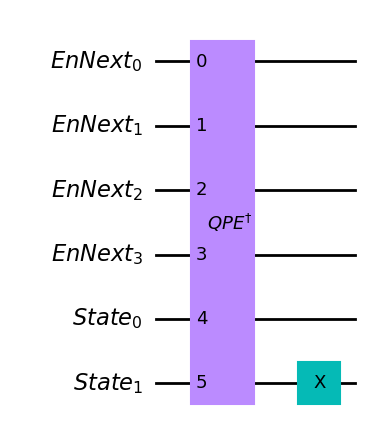

In [21]:
## TEST
en_next = QuantumRegister(4, name = 'EnNext')
st = QuantumRegister(2, name = 'State')

test_qc = QuantumCircuit(st, en_next)

test_qc.append(reject_step(en_next, st, 0.5),[*en_next, *st])

In [11]:
def accept_step(energyCurrent, energyNext, state, u):
    
    
    accept_circuit = QuantumCircuit(energyNext, state, energyCurrent, name = 'Accept')

    for index in range(0, len(energyNext)):
        accept_circuit.swap(energyNext[index], energyCurrent[index])
    
    if u == 1:
        accept_circuit.x(state[0])
    else:
        accept_circuit.x(state[1])
    
    accept_circuit.append(inverse_quantum_phase_estimation(energyNext, state, U_Dagger_Gate), [*energyNext, *state])
        
    if u == 1:
        accept_circuit.x(state[0])
    else:
        accept_circuit.x(state[1])
    
    #display(accept_circuit.draw('mpl'))
    accept_circuit = accept_circuit.to_gate()
    
    
    return accept_circuit

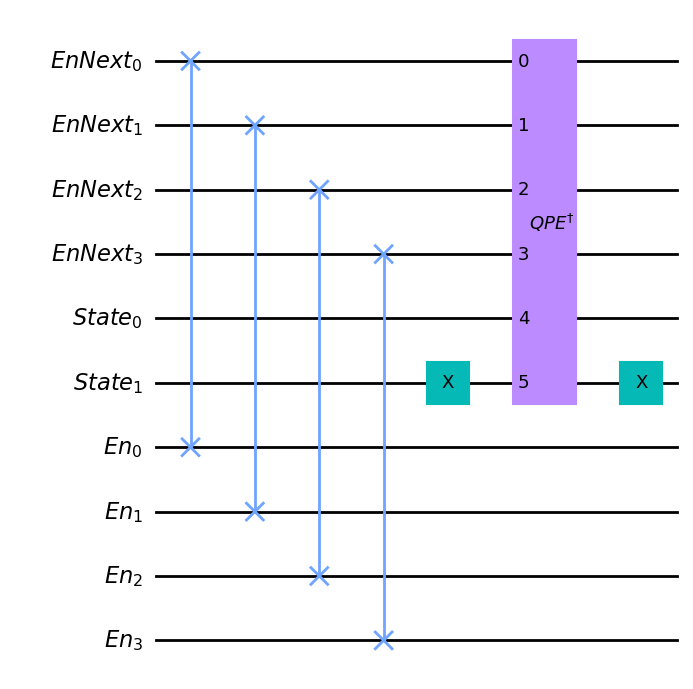

In [27]:
## TEST
en_next = QuantumRegister(4, name = 'EnNext')
st = QuantumRegister(2, name = 'State')
en = QuantumRegister(4, name = 'En')

test_qc = QuantumCircuit(en_next, st, en)

test_qc.append(accept_step(en, en_next, st, 0.5),[*en_next, *en, *st])

# QMH Algorithm

The initial state $| \psi \rangle_S$ is an eigenstate of the Hamiltonian
\begin{equation}
        \hat{H} = \frac{1}{4}(\lambda_0 - \lambda_1 - \lambda_2 + \lambda_3)\hat{\sigma}^1_z \otimes \hat{\sigma}^2_z + \frac{1}{4}(\lambda_0 + \lambda_1 + \lambda_2 + \lambda_3)\hat{\mathit{I}}^1_2 \otimes \hat{\mathit{I}}^2_2 + \frac{1}{4}(\lambda_0 - \lambda_1 + \lambda_2 - \lambda_3)\hat{\mathit{I}}^1_2 \otimes \hat{\sigma}^2_z + \frac{1}{4}(\lambda_0 + \lambda_1 - \lambda_2 - \lambda_3)\hat{\sigma}^1_z \otimes \hat{\mathit{I}}^2_2,
\end{equation}
with eigenvalues $\lambda_1$, $\lambda_2$, $\lambda_3$, $\lambda_4$ such that
\begin{equation}
    \lambda_i = \frac{\sum^N_{j=1} |dr^{model,i}_j - dr^{data}_j |}{N}
\end{equation}
where
\begin{equation}
    dr^{model,i}_j = a^{i} (b - r_{0,j})dt + \sigma W_t - r_{0,j}
\end{equation}
is given by the Vasicek model prediction. The overall initial state is
\begin{equation}
| \psi \rangle_S | 0 \rangle_{Next} |0 \rangle_{Curr} |  0 \rangle_C.
\end{equation}
After the first phase estimation,
\begin{equation}
    \hat{U}_{QPE} | \psi \rangle_S | 0 \rangle_{Next} |0 \rangle_{Curr} |  0 \rangle_C = \frac{1}{2^r} \sum^{2^r - 1}_{x = 0} \sum^{2^r - 1}_{k = 0} e^{- \frac{2 \pi i k}{2^r} (x - 2^r \alpha_{\psi})} | \psi \rangle_S | x \rangle_{Next} |0 \rangle_{Curr} |  0 \rangle_C = \sum^{2^r - 1}_{x = 0} p_x(\alpha_{\psi}) | \psi \rangle_S | x \rangle_{Next} |0 \rangle_{Curr} |  0 \rangle_C = | \psi \rangle_S | E_{\psi} \rangle_{Next} |0 \rangle_{Curr} |  0 \rangle_C.
\end{equation}
with $ p_x(\alpha_{\psi}) = \frac{1}{2^r} \sum^{2^r - 1}_{k = 0} e^{- \frac{2 \pi i k}{2^r} (x - 2^r \alpha_{\psi})}$, and
\begin{equation}
    | E_{\psi} \rangle_{Next} = \sum^{2^r - 1}_{x = 0} p_x(\alpha_{\psi}) | x \rangle_{Next}.
\end{equation}


Then we apply $r$ CNOT gates
\begin{equation}
\hat{U}^{r}_{CNOT}\sum^{2^r - 1}_{x = 0} p_x(\alpha_{\psi}) | \psi \rangle_S | x \rangle_{Next} |0 \rangle_{Curr} |  0 \rangle_C = | \psi \rangle_S \sum^{2^r - 1}_{x = 0} p_x(\alpha_{\psi}) | x \rangle_{Next} |x \rangle_{Curr} |  0 \rangle_C.
\end{equation}
With an inverse quantum phase estimation,
\begin{equation}
\hat{U}^{\dagger}_{QPE} | \psi \rangle_S \sum^{2^r - 1}_{x = 0} p_x(\alpha_{\psi}) | x \rangle_{Next} |x \rangle_{Curr} |  0 \rangle_C = | \psi \rangle_S  | 0 \rangle_{Next} |E_{\psi} \rangle_{Curr} |  0 \rangle_C.
\end{equation}
The random walk changes the system state to 
\begin{equation}
    | \psi' \rangle_S = \hat{W}| \psi \rangle_S,
\end{equation}
where the walk is, in this case, just a single spin flip.


A second quantum phase estimation calculates the new state energy,
\begin{equation}
    \hat{U}_{QPE} | \psi' \rangle_S  | 0 \rangle_{Next} |E_{\psi} \rangle_{Curr} |  0 \rangle_C = | \psi' \rangle_S  | E_{\psi'} \rangle_{Next} |E_{\psi} \rangle_{Curr} |  0 \rangle_C
\end{equation}
Applying the Boltzmann coin transformation to this state,
\begin{equation}
    \hat{U}_{CR}(\theta) | \psi' \rangle_S  | E_{\psi'} \rangle_{Next} |E_{\psi} \rangle_{Curr} |  0 \rangle_C =  | \psi' \rangle_S \sum^{2^r - 1}_{x = 0} p_x(\alpha_{\psi})\sum^{2^r - 1}_{x' = 0} p'_x(\alpha_{\psi'}) \hat{R}_y(\theta_{x'x}) | x' \rangle_{Next} |x \rangle_{Curr}|  1 \rangle_C,
\end{equation}
where
\begin{equation}
\theta_{x'x} = 2 \arccos \sqrt{\exp{-\beta}}
\end{equation}

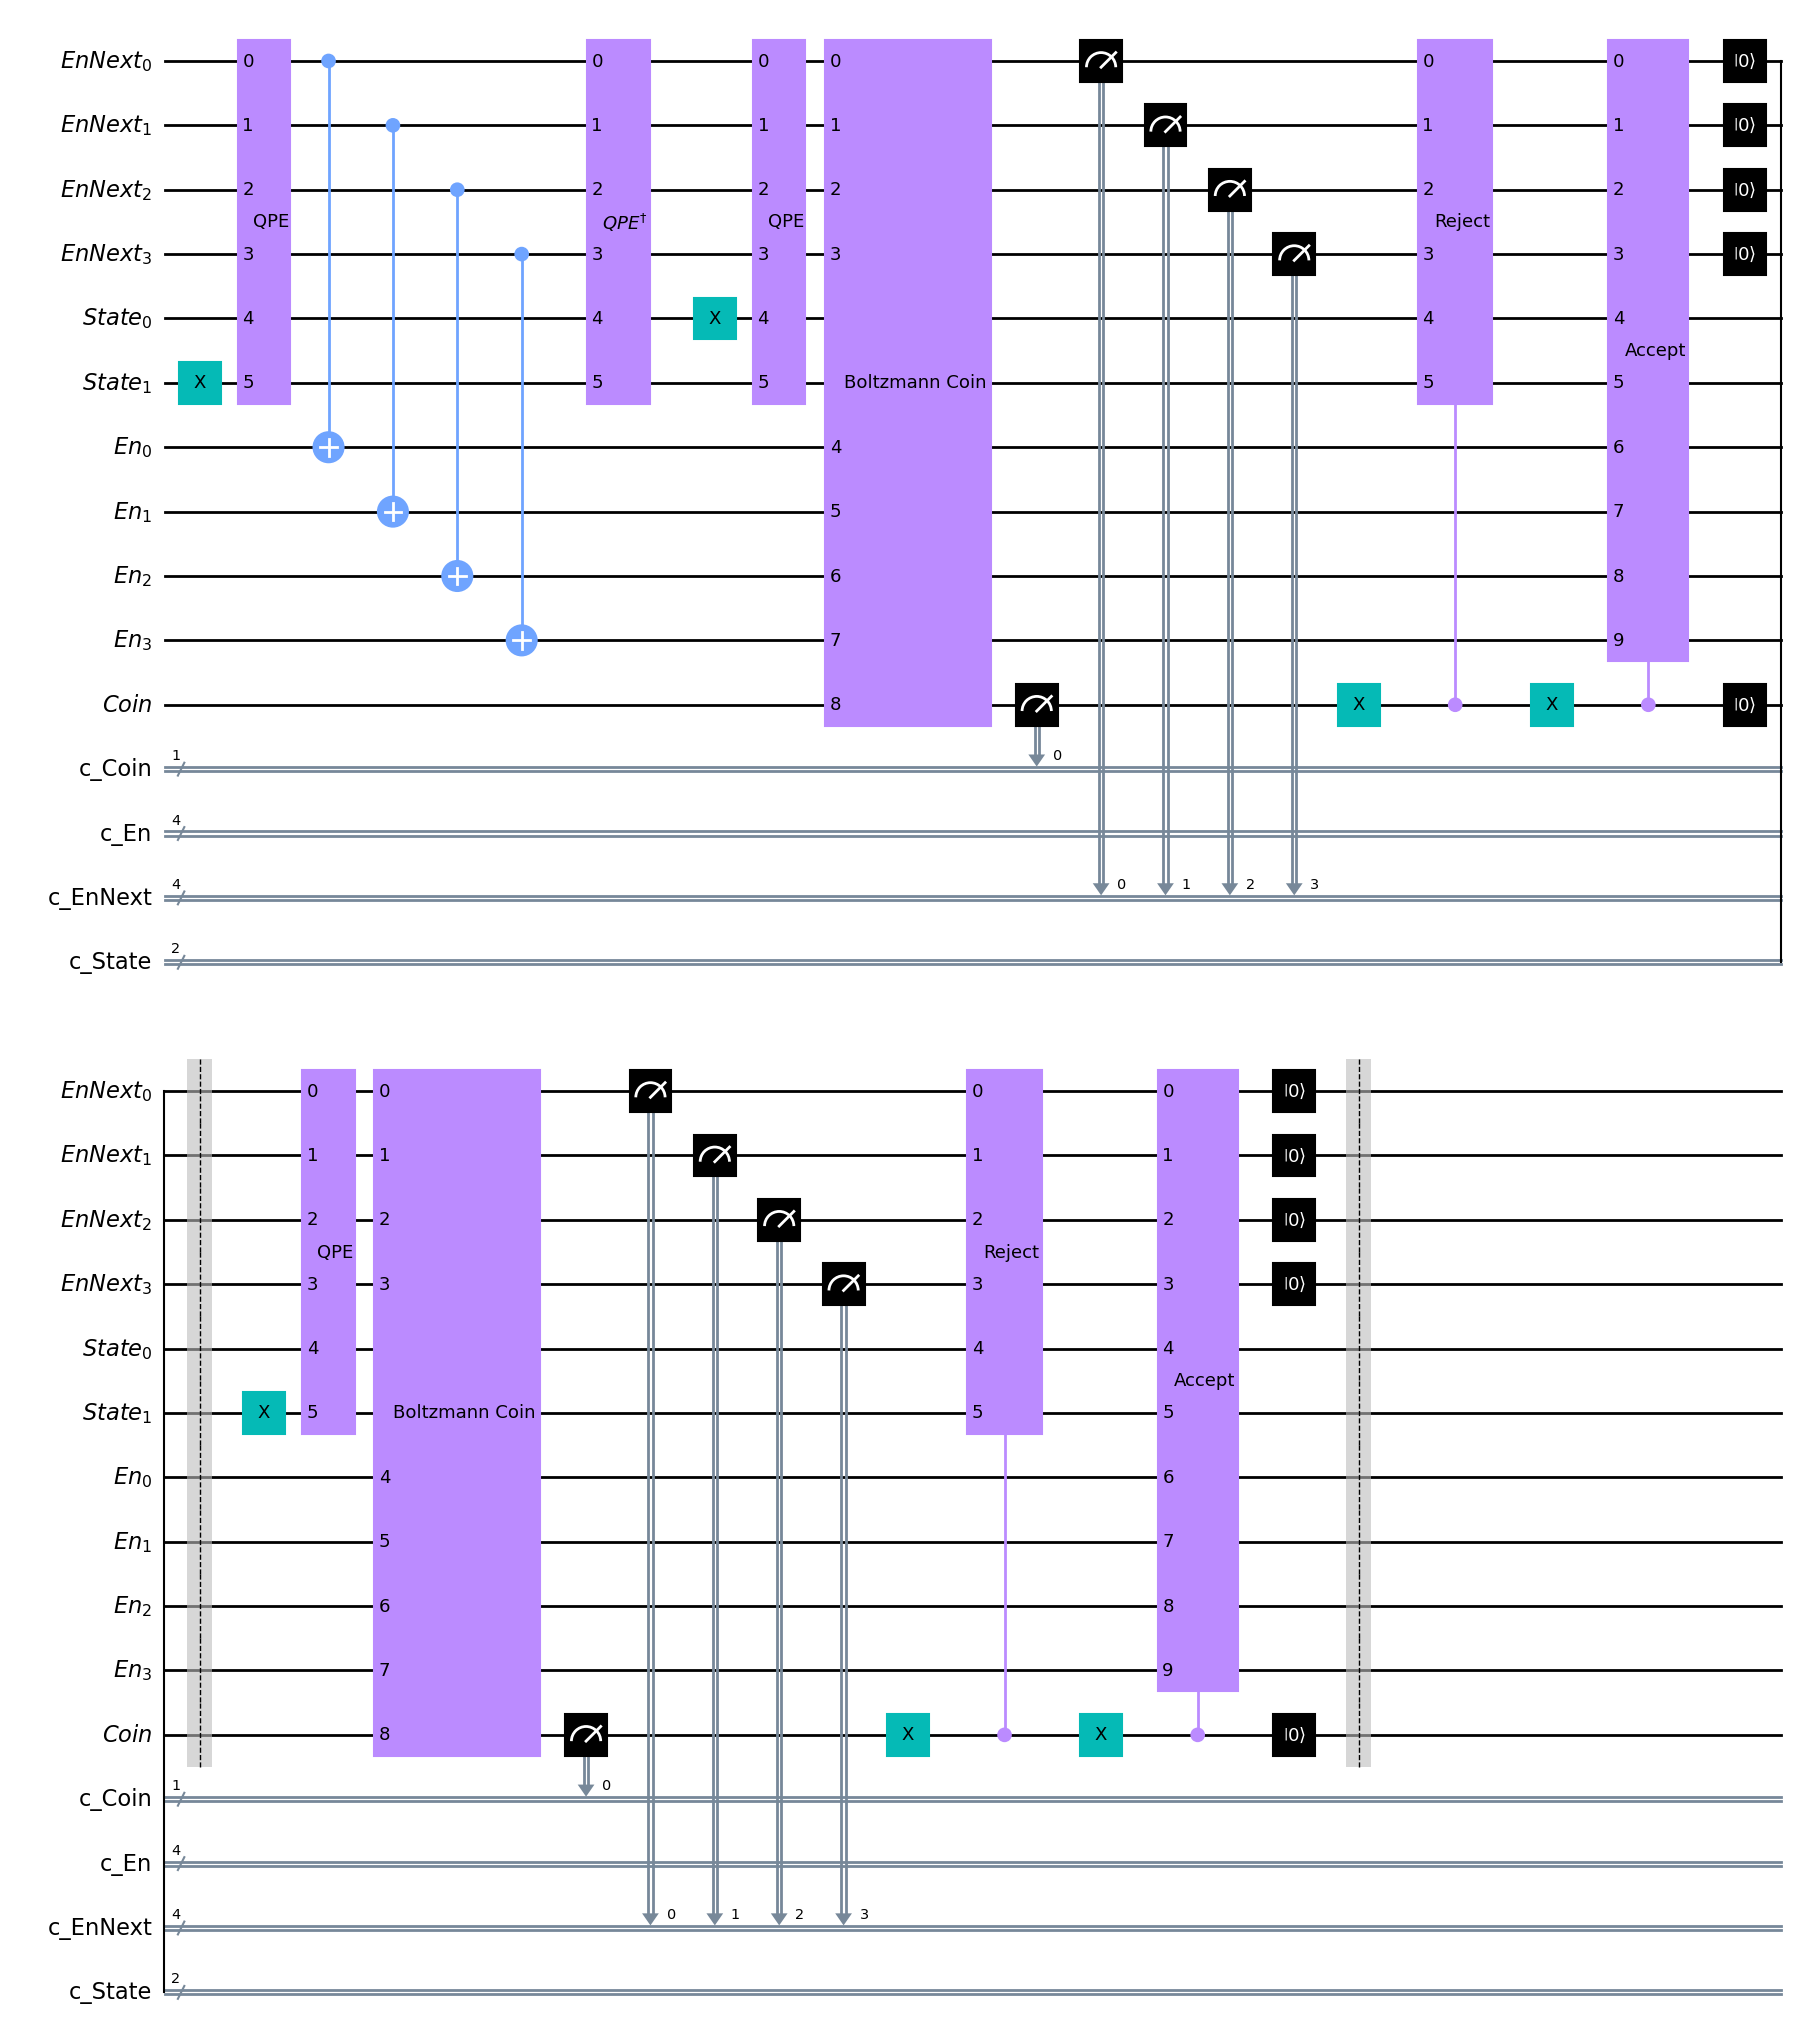

{'00 0100 1111 0': 2, '11 0011 1111 0': 2, '00 0010 1111 0': 2, '00 0011 1111 0': 2, '00 1011 1111 0': 1, '11 0111 1111 0': 1, '11 0010 1111 0': 2, '00 1101 1111 0': 2, '11 1101 1110 0': 1, '11 1010 1110 0': 2, '01 1101 1101 1': 1, '11 1101 1101 1': 1, '11 1100 1110 0': 21, '00 0101 1111 0': 1, '11 0001 1111 0': 5, '10 1111 1111 1': 3, '01 1110 1110 1': 5, '11 1000 1111 0': 3, '11 1111 1111 1': 5, '11 1101 1111 0': 31, '11 1010 1111 0': 11, '11 0110 1111 0': 2, '10 1100 1100 1': 2, '11 1110 1111 0': 5, '11 0000 1111 0': 7, '00 1010 1111 0': 2, '10 0000 1111 0': 1, '00 1100 1111 0': 2, '10 1110 1110 1': 4, '11 1001 1111 0': 3, '00 0111 1111 0': 1, '10 1110 1111 0': 2, '00 0000 1111 0': 12, '00 0001 1111 0': 2, '11 1011 1110 0': 5, '00 1110 1111 0': 12, '11 1011 1111 0': 63, '00 1111 1111 1': 782, '01 1111 1111 1': 660, '11 1100 1111 0': 329}


In [12]:
import random

state_bits = 2
energy_bits = 4
iterations = 50

    
# Quantum registers


next_energy_register = QuantumRegister(energy_bits,name='EnNext')

state_register = QuantumRegister(state_bits,name='State')

current_energy_register = QuantumRegister(energy_bits,name='En')

coin_register = QuantumRegister(1, name='Coin')

# Classical register

nextEn_classical_register = ClassicalRegister(energy_bits, name = 'c_EnNext')

currentEn_classical_register = ClassicalRegister(energy_bits, name = 'c_En')

coin_classical_register = ClassicalRegister(1, name = 'c_Coin')

state_classical_register = ClassicalRegister(state_bits, name = 'c_State')

# Create circuit

qc = QuantumCircuit(next_energy_register, state_register, current_energy_register, coin_register)
qc.add_register(coin_classical_register)
qc.add_register(currentEn_classical_register)
qc.add_register(nextEn_classical_register)
qc.add_register(state_classical_register)

def QMH(circuit, state_bits, energy_bits, it):

    # Initialize circuit

    u0 = random.randrange(2)

    if u0 == 1:
        circuit.x(state_register[0])
    else:
        circuit.x(state_register[1])
    
    # PHASE ESTIMATION
    
    circuit.append(quantum_phase_estimation(next_energy_register, state_register, U_Gate),[*next_energy_register, *state_register])


    # COPY OF ENERGY VALUE   
    
    
    for index in range(0, energy_bits):
        circuit.cx(next_energy_register[index], current_energy_register[index])
    
    circuit.append(inverse_quantum_phase_estimation(next_energy_register, state_register, U_Gate),[*next_energy_register, *state_register])


    #for qubit in next_energy_register:
        #circuit.reset(qubit)
        

    # Iterative circuit

    count = 0
    for _ in range(it):
    
    
        # RANDOM WALK STEP: SINGLE-SPIN FLIP
        u = random.randrange(2)

        if u == 1:
            circuit.x(state_register[0])
        else:
            circuit.x(state_register[1])

        # PHASE ESTIMATION

        circuit.append(quantum_phase_estimation(next_energy_register, state_register, U_Gate),[*next_energy_register, *state_register])

        # BOLTZMANN COIN

        circuit.append(boltzmann_coin(current_energy_register,next_energy_register, coin_register),[*next_energy_register, *current_energy_register, coin_register])
    
        # Measure

        circuit.measure(coin_register, coin_classical_register)


        # Reject new step : 0
        circuit.measure(next_energy_register, nextEn_classical_register)
        
        circuit.x(coin_register)

        circuit.append(reject_step(next_energy_register, state_register, u).control(1), [coin_register, *next_energy_register, *state_register])

        circuit.x(coin_register)
        

        # Accept new step : 1
        
        circuit.append(accept_step(current_energy_register, next_energy_register, state_register, u).control(1), [coin_register, *next_energy_register, *state_register, *current_energy_register])

        circuit.reset(coin_register)
        for qubit in next_energy_register:
            circuit.reset(qubit)
        
        
        circuit.barrier()
        
        if count == 1:
            display(circuit.draw('mpl'))
            
        count = count + 1
        
    return circuit

    
QMH(qc, state_bits, energy_bits, iterations)

#
#qc.measure(next_energy_register, nextEn_classical_register)
qc.measure(state_register, state_classical_register)
qc.measure(current_energy_register, currentEn_classical_register)



# Simulation

simulator = Aer.get_backend('qasm_simulator')
count0 = execute(qc, simulator, shots = 2000).result().get_counts()
print(count0)

Ground state energy found by QMH: 0.39269908169872414
Lowest eigenvalue of Hamiltonian: 0.3913271011298079


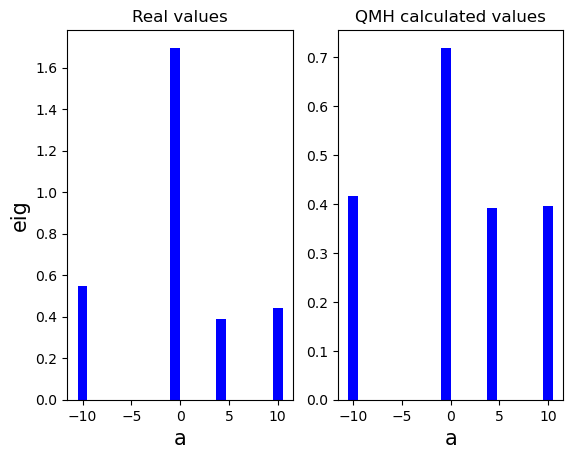

In [32]:
eigenstates = ['00', '01', '10', '11']
en = []
count_list = []
for st in eigenstates:
    count = 0
    energy = 0
    
    for index in range(0, len(read_output(count0)[0])):
        if read_output(count0)[0][index] == st:
            count = count + list(count0.values())[index]
            energy = energy + list(count0.values())[index]*read_output(count0)[1][index]
            
    count_list.append(count)
    en.append(energy/count)
    

min_index  = en.index( min(en) )
min_index2 = eigenvalues.index( min(eigenvalues) )
print("Ground state energy found by QMH: " + str(en[min_index]))
print("Lowest eigenvalue of Hamiltonian: " + str(eigenvalues[min_index2]))

    
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(a_list, eigenvalues, color ='blue', width=1)
ax1.set_xlabel('a',fontsize=15)
ax1.set_ylabel('eig', fontsize=15)
ax1.title.set_text('Real values')

ax2.bar(a_list, en, color ='blue', width=1)
ax2.set_xlabel('a',fontsize=15)
ax2.title.set_text('QMH calculated values')

In [33]:
a_list

[4.2, 10, -0.5, -10]

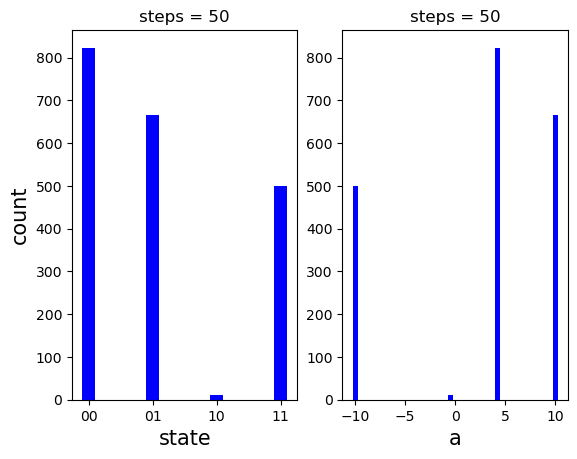

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2)

ax1.bar(eigenstates, count_list, color ='blue', width=0.2)
ax1.set_xlabel('state', fontsize = 15)
ax1.set_ylabel('count', fontsize=15)
ax1.title.set_text('steps = ' + str(iterations))

ax2.bar(a_list, count_list, color ='blue', width=0.5)
ax2.set_xlabel('a',fontsize=15)
ax2.title.set_text('steps = ' + str(iterations))
